# Ultimate Data Science Challenge

In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
% matplotlib inline

Part 1 ‑ Exploratory data analysis
The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15­minute time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

In [2]:
logins = pd.read_json('logins.json')
logins.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 1.4 MB


In [3]:
logins = logins.sort_values('login_time')
logins['lt_rounded'] = logins.login_time.dt.round('15min')

In [4]:
logins.tail(10)

,login_time,lt_rounded
93133,1970-04-13 18:40:31,1970-04-13 18:45:00
93135,1970-04-13 18:40:40,1970-04-13 18:45:00
93131,1970-04-13 18:43:19,1970-04-13 18:45:00
93138,1970-04-13 18:43:56,1970-04-13 18:45:00
93134,1970-04-13 18:46:06,1970-04-13 18:45:00
93136,1970-04-13 18:48:52,1970-04-13 18:45:00
93137,1970-04-13 18:50:19,1970-04-13 18:45:00
93139,1970-04-13 18:54:02,1970-04-13 19:00:00
93141,1970-04-13 18:54:23,1970-04-13 19:00:00
93140,1970-04-13 18:57:38,1970-04-13 19:00:00


In [5]:
logins.dtypes

login_time    datetime64[ns]
lt_rounded    datetime64[ns]
dtype: object

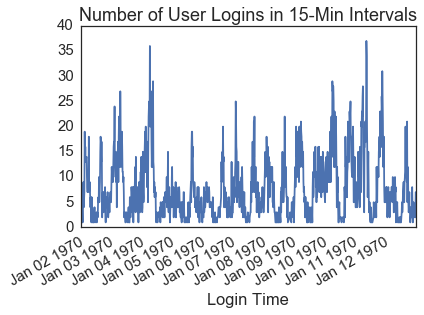

In [6]:
plt.figsize=(17,4)
logins.groupby(['lt_rounded']).count()[:1000].plot(legend=False)
plt.title('Number of User Logins in 15-Min Intervals')
plt.xlabel('Login Time')
plt.show()

So we see clear cyclicality happening, from the rough look I think its weekly... lets see

In [7]:
logins['weekday'] = logins.lt_rounded.dt.weekday
logins['count'] = 1

In [8]:
count_weekday = logins.groupby('weekday').sum()

In [9]:
count_weekday = logins.groupby('weekday').sum()
count_weekday.index = ['Mon', 'Tues', 'Wed','Thurs','Fri', 'Sat', 'Sun']
count_weekday.reset_index(inplace=True)
count_weekday

,index,count
0,Mon,8836
1,Tues,9251
2,Wed,10301
3,Thurs,11963
4,Fri,15172
5,Sat,19415
6,Sun,18204


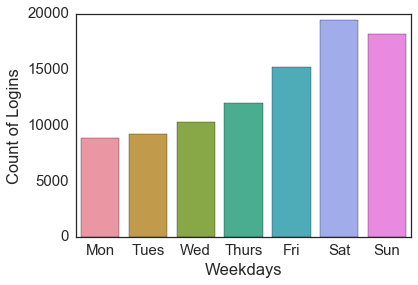

In [10]:
count_weekday = logins.groupby('weekday').sum()
count_weekday.index = ['Mon', 'Tues', 'Wed','Thurs','Fri', 'Sat', 'Sun']
count_weekday.reset_index(inplace=True)
sns.barplot(x='index', y='count', data=count_weekday)
plt.xlabel('Weekdays')
plt.ylabel('Count of Logins')

Indeed, indeed it is a weekly pattern, the weekend dominates, as does Friday. This is likely a 'free time' or 'social time' type of application. I wonder if this is based up by time of day... 

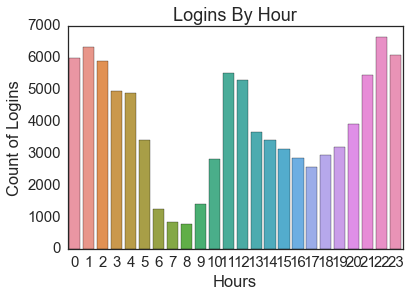

In [11]:
logins['hour'] = logins.lt_rounded.dt.hour
count_hour = logins.groupby('hour').sum()
count_hour.reset_index(inplace=True)
sns.barplot(x='hour', y='count', data=count_hour)
plt.xlabel('Hours')
plt.ylabel('Count of Logins')
plt.title('Logins By Hour')

Indeed, sleep, and work hours are negativaly coorelated with login time. But Lunch and late into the night are strong user times. Maybe a Dating app? 

## Part 2 ‑ Experiment and metrics design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.

1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?

2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:
  
  a. how you will implement the experiment
  
  b. what statistical test(s) you will conduct to verify the significance of the
observation
  
  c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

1. This is at its heart a Time-Resource Allocation problem. Meaning, the needed resources vary with time. On weekends the drivers seem to be evenly split based on activity, but weeknights and days we have a missallocation. So what Success KPI would be is Total Gotham Drivers Active in Metropolis during the weekday, and Total Metropolis Drivers Active in Gotham during the weeknight, both normalized to the total number of drivers in either city at that sametime. 

The reason being, we don't care if they are crossing the bridge X# of times, or if they are doing this during the weekend. Furthermore, these two KPIs are Directional to the Problem. 

2. I assume we have access to a Phone with GPS data. 
a. Take Pilot population of random 20% of drivers (the correct size depends on the total number of drivers)
I would have them split again 50/50 Gotham/Metropolis Drivers
On net, its two test sets and a balanced control population. 
Make them eligible for the toll program. This works best, if the reimbursement is immediate, as it removes time-value of money / cash-flow considerations. 

I would run this for at least 1 month since we want to observe the difference in weekday activity, but we will want to compare that overall activity for normalization purposes. 

The number we are looking for the Percentage of Metropolis Drivers Active in Gotham during the weeknight, and the Percentage of Gotham Drivers Active in Metropolis during the weekday, relative to the balanced control groups. 

In this case a one-tailed z-test would be able to tell you if there is any net change in the % of drivers at peaks times between the test and the control populations. 

Some caveats - 
1. I split the two cities drivers on purpose, because one set might be more induced to drive more then the other with the toll refund, so it will be interesting to see how those groups shake out. 
2. Airport trips can create various complications if its located in one, but officially not the other city. 
3. Is this a net-profitable program, tolls going both ways can add up, and if the change isn't large enough to drive the required volume of cross city switching, its not a good program.


### Part 3 ‑ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?

2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.

3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its long­term rider retention (again, a few sentences will suffice).

In [12]:
with open('ultimate_data_challenge.json') as f:
    data = json.load(f)
dvrs = pd.DataFrame(data)

In [13]:
dvrs.describe()

/Users/RBennington/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,NaN,NaN,1.000000,0.000000,0.000000,33.300000
50%,3.880000,NaN,NaN,1.000000,0.000000,1.000000,66.700000
75%,6.940000,NaN,NaN,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


In [14]:
dvrs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


## Data Clean Steps

#### Missing Data
* Create Retained Catagory 1 or 0 
* Use mean for avg_rating_of_driver, avg_rating_by_driver as its functionally true, and the skew would be limited
* Phone is going to be binerized, so not worries there.  

#### Format Data

* signup_date, last_trip_date to DateTimes
* Binerized city, phone, and ultimate_black_user

In [15]:
dvrs['signup_date'] = pd.to_datetime(dvrs['signup_date'])
dvrs['last_trip_date'] = pd.to_datetime(dvrs['last_trip_date'])

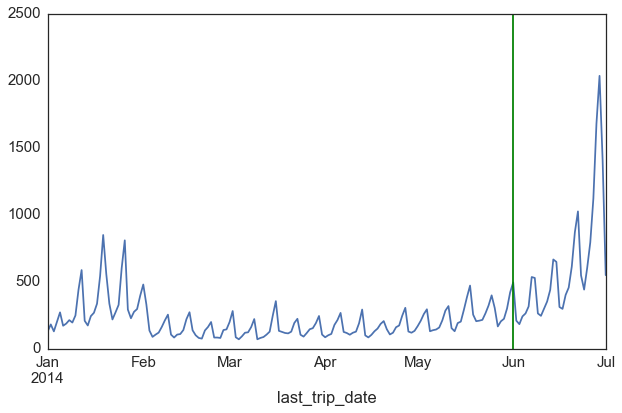

In [16]:
dvrs.groupby('last_trip_date').size().plot(figsize=(10,6))
plt.axvline(x='2014-06-01', color='green')
plt.show()

In [17]:
# the we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days
dvrs['retain'] = (dvrs.last_trip_date >= '2014-06-01').astype(int)

In [18]:
dvrs.retain.value_counts()

0    31196
1    18804
Name: retain, dtype: int64

In [19]:
dvrs.shape[0]

50000

In [20]:
print('The fraction of users that are retained is {}%.'.format((18804/50000)))

The fraction of users that are retained is 0%.


In [21]:
# Calculate percentage of retained users
ret = dvrs.retain.sum()
total = dvrs.shape[0]
frac_retain = 18 / 50
print('The fraction of users that are retained is {:.1f}%.'.format(frac_retain*1000))

The fraction of users that are retained is 0.0%.


#### The ANSWER IS 36%, why I am getting a 0.0% is still annoying me. 

In [22]:
dvrs.avg_rating_by_driver.fillna(dvrs.avg_rating_by_driver.mean(), inplace=True)
dvrs.avg_rating_of_driver.fillna(dvrs.avg_rating_of_driver.mean(), inplace=True)

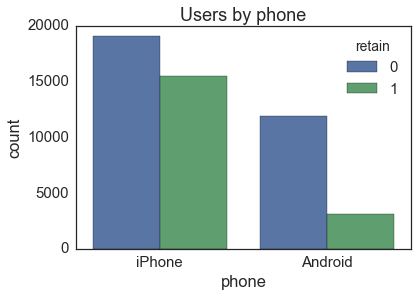

In [23]:
sns.countplot(x='phone', hue='retain', data=dvrs)
plt.title('Users by phone')

In [24]:
#this is about iPhones, so lets use that as the primary
dvrs['phone'] = dvrs['phone'].fillna('nan')
dvrs['iphone'] = np.where(map(lambda k: 'iPhone' in k, dvrs.phone), '1', '0')

In [25]:
dvrs.ultimate_black_user = (dvrs.ultimate_black_user).astype(int)

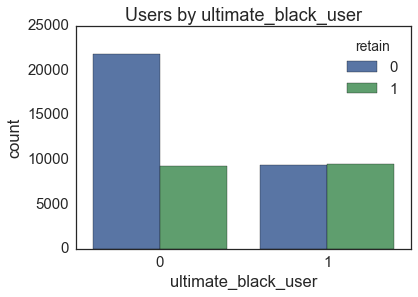

In [26]:
sns.countplot(x='ultimate_black_user', hue='retain', data=dvrs)
plt.title('Users by ultimate_black_user')

So black is associated more strongly with retained people. 

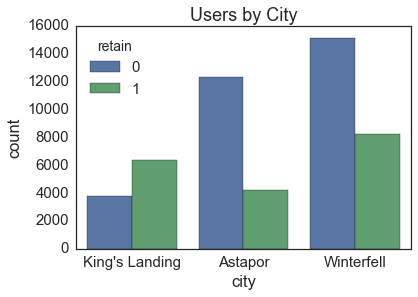

In [27]:
sns.countplot(x='city', hue='retain', data=dvrs)
plt.title('Users by City')

In [28]:
#Those string names have GOT TO GO! 
dvrs['city'] = dvrs['city'].map({"King's Landing" : "kings", "Astapor" : "astapor", "Winterfell": "winterfell"})

Winterfell is the largest overall, but Kings does best for retaining, and Astapor seems to do the worst, so I want to look at them for those reasons. 

In [29]:
dvrs['kings'] = np.where(map(lambda k: 'kings' in k, dvrs.city), '1', '0')
dvrs['astapor'] = np.where(map(lambda k: 'astapor' in k, dvrs.city), '1', '0')

In [30]:
dvrs.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retain,iphone,kings,astapor
0,3.67,5.0,4.7,1.10,kings,2014-06-17,iPhone,2014-01-25,15.4,4,1,46.2,1,1,1,0
1,8.26,5.0,5.0,1.00,astapor,2014-05-05,Android,2014-01-29,0.0,0,0,50.0,0,0,0,1
2,0.77,5.0,4.3,1.00,astapor,2014-01-07,iPhone,2014-01-06,0.0,3,0,100.0,0,1,0,1
3,2.36,4.9,4.6,1.14,kings,2014-06-29,iPhone,2014-01-10,20.0,9,1,80.0,1,1,1,0
4,3.13,4.9,4.4,1.19,winterfell,2014-03-15,Android,2014-01-27,11.8,14,0,82.4,0,0,0,0


Thats good for the catagorials, but lets viz the numerical data to get a sense of it. 

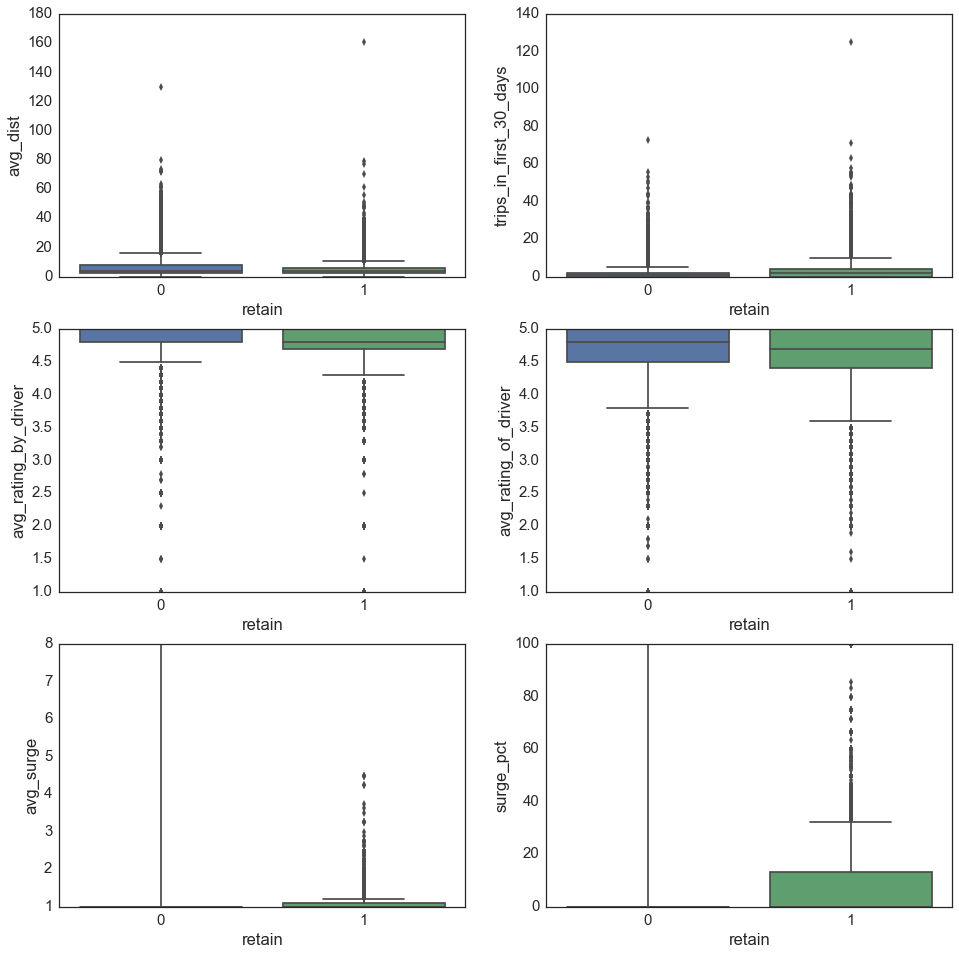

In [31]:
fig, ax = plt.subplots(nrows=3, ncols=2)
fig.set_size_inches(16, 16)
plt.subplot(3, 2, 1)
sns.boxplot(y='avg_dist', x='retain', data=dvrs)
plt.subplot(3, 2, 2)
sns.boxplot(y='trips_in_first_30_days', x='retain', data=dvrs)
plt.subplot(3, 2, 3)
sns.boxplot(y='avg_rating_by_driver', x='retain', data=dvrs)
plt.subplot(3, 2, 4)
sns.boxplot(y='avg_rating_of_driver', x='retain', data=dvrs)
plt.subplot(3, 2, 5)
sns.boxplot(y='avg_surge', x='retain', data=dvrs)
plt.subplot(3, 2, 6)
sns.boxplot(y='surge_pct', x='retain', data=dvrs)


Some intersting stuff here, distance seems slightly negatively coorelated to remaing active. But as you would expect taking a greater number of trips in the first 30days is a good sign of retention. 

The ratings by and for drivers seem even across both populations. Most ratings are very high, and then you see a long long tail of below Fours. 

Active people pay more surge prices. 

All of these should get normalized via standard scaler as best practice. 

I also don't want to drop the Account Created feature, so I am and going to turn it into an account age feature. 


In [32]:
end = datetime.date(2014,6,1)
dvrs['account_age'] = end - dvrs['signup_date']
dvrs['account_age']  = (dvrs['account_age'] / np.timedelta64(1, 'D')).astype(int)

In [33]:
dvrs.head()
#I'm happy with this. 

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retain,iphone,kings,astapor,account_age
0,3.67,5.0,4.7,1.10,kings,2014-06-17,iPhone,2014-01-25,15.4,4,1,46.2,1,1,1,0,127
1,8.26,5.0,5.0,1.00,astapor,2014-05-05,Android,2014-01-29,0.0,0,0,50.0,0,0,0,1,123
2,0.77,5.0,4.3,1.00,astapor,2014-01-07,iPhone,2014-01-06,0.0,3,0,100.0,0,1,0,1,146
3,2.36,4.9,4.6,1.14,kings,2014-06-29,iPhone,2014-01-10,20.0,9,1,80.0,1,1,1,0,142
4,3.13,4.9,4.4,1.19,winterfell,2014-03-15,Android,2014-01-27,11.8,14,0,82.4,0,0,0,0,125


In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

In [35]:
dvrs.columns

Index([              u'avg_dist',   u'avg_rating_by_driver',
         u'avg_rating_of_driver',              u'avg_surge',
                         u'city',         u'last_trip_date',
                        u'phone',            u'signup_date',
                    u'surge_pct', u'trips_in_first_30_days',
          u'ultimate_black_user',            u'weekday_pct',
                       u'retain',                 u'iphone',
                        u'kings',                u'astapor',
                  u'account_age'],
      dtype='object')

In [36]:
#stuff we don't need
tm = dvrs.drop(['city',
               'phone',
               'last_trip_date',
               'signup_date'], axis=1)

In [37]:
# Split data
y = np.array(tm.retain)
X = np.array(tm.drop('retain', axis=1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [38]:
# Normalize data
scaler = StandardScaler()
scaler.fit(X_train) # use train data to fit
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

/Users/RBennington/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### Logistic
Why? I mean its the classic, its fast, and serves as the benchmark. 

In [39]:
# Grid Search
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
logc = GridSearchCV(LogisticRegression(penalty='l2'), param_grid)
logc.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [40]:
# View best hyperparameters
print('Best C:', logc.best_estimator_.get_params()['C'])

('Best C:', 0.1)


In [41]:
#Run the Logistic regression with the best C
log_model = LogisticRegression(C=0.01, class_weight='balanced')
log_model.fit(X_train, y_train)
y_pred=log_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Inactive', 'Retained']))

             precision    recall  f1-score   support

   Inactive       0.78      0.72      0.75     10305
   Retained       0.59      0.67      0.63      6195

avg / total       0.71      0.70      0.70     16500



In [42]:
#ROC Score
fpr, tpr, thresholds = roc_curve(y_train, log_model.predict_proba(X_train)[:, 1])
auc = roc_auc_score(y_test, log_model.predict_proba(X_test)[:, 1])
print("AUC: {}".format(auc))

AUC: 0.760758222088


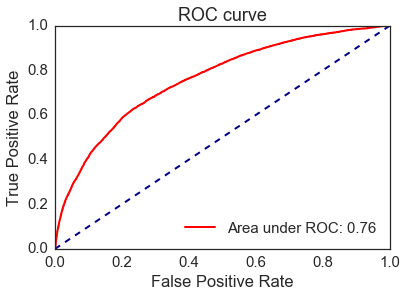

In [43]:
plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label='Area under ROC: {:.2f}'.format(auc))
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('ROC curve')
plt.show()

Not bad for a first pass, and 2second of tuning. 

In [44]:
# Present features importance by their corresponding coefficients in logistic regression
coef = list(zip(tm.drop('retain', axis=1).columns, log_model.coef_[0]))
log_fet  = pd.DataFrame(coef, columns=['feature', 'coefficient'])

log_fet.set_index('feature').sort_values('coefficient', ascending=False)

,coefficient
feature,
iphone,0.486252
kings,0.475750
trips_in_first_30_days,0.470885
ultimate_black_user,0.408469
surge_pct,0.074626
account_age,0.054440
weekday_pct,-0.011131
avg_rating_of_driver,-0.024537
avg_surge,-0.037734


### Logistic Story
iPhones are really important to retention, that might indicate an Android Experience that is lacking, or it might be acting a socail status marker. 

Kings Landing, I feel like this is Manhatten, and Astapor is Queens. Mixed with the iPhone, and Ultimate Black User, what you see a social demographic that is mobile, rich, and never leaves the Island, as seen by the Avg Distance. 

### GradientBoostingClassifier
Lets try something else to see how it compares. GradientBoosting trains slowly, but the results are often better. 

In [45]:
# Use gridsearch for tuning parameters
gb = GradientBoostingClassifier()
parameters = {'learning_rate':[0.01, 0.1, 0.2, 0.3], 'n_estimators':[150, 200, 250, 300]}
gbc = GridSearchCV(gb, parameters, cv=5, scoring='accuracy')
gbc.fit(X_train, y_train)
gbc.best_params_

{'learning_rate': 0.1, 'n_estimators': 300}

In [51]:
gb = GradientBoostingClassifier(learning_rate=0.1, n_estimators=300)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Inactive', 'Retained']))

             precision    recall  f1-score   support

   Inactive       0.81      0.86      0.84     10305
   Retained       0.74      0.67      0.70      6195

avg / total       0.79      0.79      0.79     16500



In [52]:
#ROC Score
fpr, tpr, thresholds = roc_curve(y_train, gb.predict_proba(X_train)[:, 1])
auc = roc_auc_score(y_test, gb.predict_proba(X_test)[:, 1])
print("AUC: {}".format(auc))

AUC: 0.85439266222


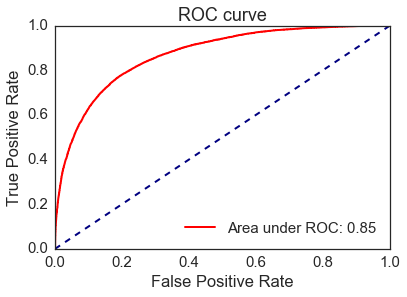

In [53]:
plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label='Area under ROC: {:.2f}'.format(auc))
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('ROC curve')
plt.show()

Well it took almost 8mins to train, but it gave us a 0.09% in AUC, so thats better prediction for sure. 

In [56]:
# Present features importance by their corresponding coefficients in logistic regression
coef = list(zip(tm.drop('retain', axis=1).columns, gb.feature_importances_))
fet = pd.DataFrame(coef, columns=['feature', 'coefficient'])
fet.set_index('feature').sort_values('coefficient', ascending=False)

,coefficient
feature,
avg_dist,0.171260
weekday_pct,0.164537
trips_in_first_30_days,0.158949
surge_pct,0.122941
avg_rating_by_driver,0.086963
avg_rating_of_driver,0.076412
account_age,0.060645
avg_surge,0.051859
kings,0.031948


Interpretation is much different from the Log Model. 
This story is one of business people, using the car share on the corp card, they ride during the week, the pay the surge prices, and they take a number of trips in the first 30days. The Phone, Black, and Locations are less meaningful. 

And that's good, it tells us we should focus on the Corporate Style User, people who need it to get from meeting to meeting. Furthermore, the Surge prices are usually pure profit, the less price sensitive they are, the better for the bottom line. WIN!
 

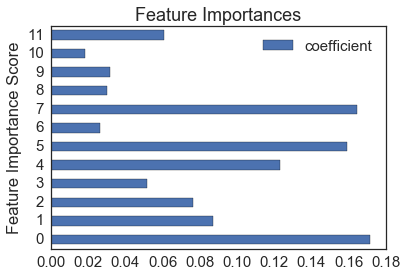

In [55]:
fet.plot(kind='barh', title='Feature Importances')
plt.ylabel('Feature Importance Score')